# 0. Problem definition

Our goal through this project will be to predict the sale price of a house based on several features related to properties. To do so we will use a dataset from Kaggle. 

## Importing libraries

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Data Collection and Loading

Let's load the data and have a first look at it.

In [2]:

# Load the training set 
df = pd.read_csv('train.csv')

# Display the first few rows of the train set to understand its structure
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We notice that we are having 81 features, some numerical, other categorical. We can already see that some NaNs are there.

# 2. Exploratory Data Analysis

## Understanding the data structure

In [3]:
# Check basic information about the dataset
df.info()

# Check for missing values in each column
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]  # Only showing columns with missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

We are having 1460 samples. We can see that the features PoolQC, MiscFeature, Alley and Fence are having a very high percentage of missing values. We will therefore drop the colums with a missing value percentage above 80%. However, for the other columns we will rather try to impute the missing values during the data cleaning and preprocessing part.

## Determining the columns to drop

In [4]:
# Set a threshold for dropping columns
threshold = 0.8  # Drop columns with more than 80% missing values

# Calculate the percentage of missing data per column
missing_percentage = df.isnull().sum() / len(df)

# List of columns to drop based on the threshold
cols_to_drop = missing_percentage[missing_percentage > threshold].index
print(f"Columns to drop: {cols_to_drop}")

Columns to drop: Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


We have now identified the columns we need to drop.

## Basic statistical summary 

In [5]:
# Summary statistics for numerical features
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


We can note that the numerical features are not distributed on the same scale.

In [6]:
# Summary statistics for categorical features
df.describe(include=['object'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


Note : We have binary features along with multiple values features

## Target Variable (SalePrice) Distribution

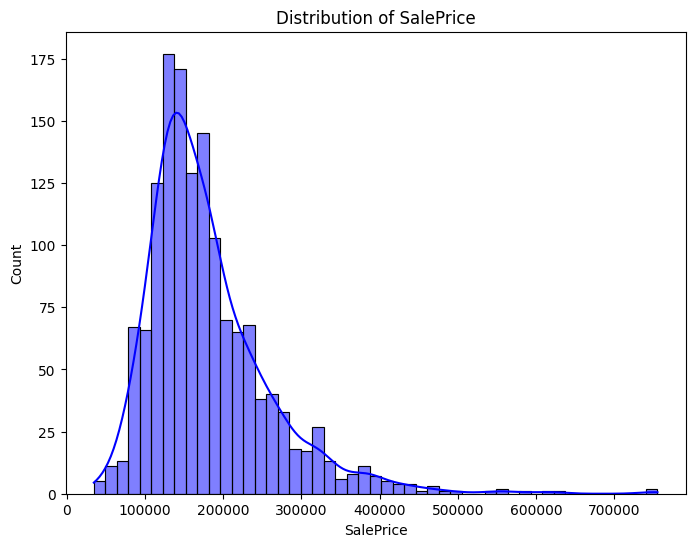

In [7]:

# Visualize the distribution of the target variable SalePrice
plt.figure(figsize=(8, 6))
sns.histplot(df['SalePrice'], kde=True, color='blue')
plt.title('Distribution of SalePrice')
plt.show()


The SalePrice distribution shows a right-skewed distribution, meaning that most houses are in the lower price range, with fewer houses at higher prices.

## Correlation Analysis

Let's now check which features are the most important correlation wise

In [8]:

# Compute correlations with SalePrice
corr_matrix = df.corr()

# Sort the correlations with SalePrice based on absolute correlation values (both positive and negative correlations)
corr_with_saleprice = corr_matrix['SalePrice'].apply(abs).sort_values(ascending=False)

# Get the data types of the columns
feature_types = df.dtypes

# Display the top correlated features with SalePrice along with their types
print("Top 10 features (considering both positive and negative correlations):\n")
for feature in corr_with_saleprice.head(10).index:
    correlation = corr_matrix['SalePrice'][feature]  # Get the actual correlation value (can be negative)
    feature_type = feature_types[feature]
    print(f"Feature: {feature}, Correlation: {correlation:.4f}, Type: {feature_type}")


Top 10 features (considering both positive and negative correlations):

Feature: SalePrice, Correlation: 1.0000, Type: int64
Feature: OverallQual, Correlation: 0.7910, Type: int64
Feature: GrLivArea, Correlation: 0.7086, Type: int64
Feature: GarageCars, Correlation: 0.6404, Type: int64
Feature: GarageArea, Correlation: 0.6234, Type: int64
Feature: TotalBsmtSF, Correlation: 0.6136, Type: int64
Feature: 1stFlrSF, Correlation: 0.6059, Type: int64
Feature: FullBath, Correlation: 0.5607, Type: int64
Feature: TotRmsAbvGrd, Correlation: 0.5337, Type: int64
Feature: YearBuilt, Correlation: 0.5229, Type: int64


/var/folders/mq/1ld9t8tj6577mpr_yq29l3sw0000gn/T/ipykernel_17329/3091596297.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


We can see that some features are highly correlated to the target variable (e.g OverallQual, GrLivArea). Moreover the most correlated features are all having a positive correlation.

## Investigating some Important Features

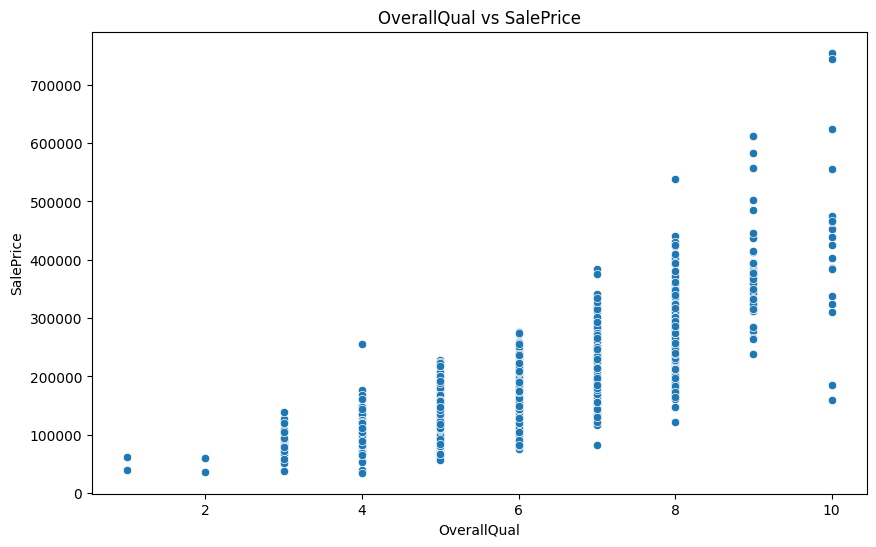

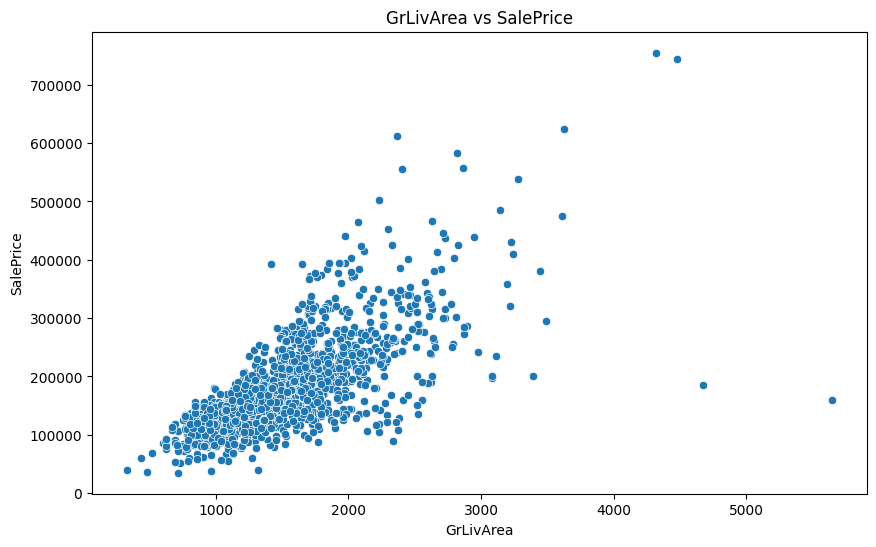

In [9]:
# Scatter plot for key features vs SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=df)
plt.title('OverallQual vs SalePrice')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
plt.title('GrLivArea vs SalePrice')
plt.show()




Except few outliners we can indeed verify that whenever the overall quality and the above ground living area are increasing then the sale price is increasing too.

# 3. Data cleaning and preprocessing

## Dropping the columns with a missing value percentage higher than 80%

In order to not keep features with only a very little set of samples, we are dropping all the columns with a missing value percentage above 80%

In [10]:
# Drop columns with a high percentage of missing values (above 80%)
df = df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

## Handling the Remaining Missing Values

Here we will handle the remaining missing values by making assumptions:

- First, the **LotFrontage** will be filled with the median value of the neighborhood.
- Second, the **GarageYrBlt** will either be:
  - Dropped if there is no garage, or
  - Imputed with the year of the house construction.
- Third, the **electrical system** (assuming every house has one) will be filled with the most common value found in our samples.


In [11]:

# Fill categorical missing values with 'None'
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

# Impute LotFrontage based on the median within each neighborhood
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Fill missing Garage-related features, assuming missing means 'None'
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
df[garage_cols] = df[garage_cols].fillna('None')

# Now, update GarageYrBlt based on GarageType:
# - If there's no garage (GarageType == 'None'), we will delete the row later.
# - If there's a garage but GarageYrBlt is missing, set GarageYrBlt to the YearBuilt.
df['GarageYrBlt'] = np.where(
    (df['GarageType'] != 'None'),  # Condition: Garage exists
    df['GarageYrBlt'].fillna(df['YearBuilt']),  # Fill with YearBuilt if garage exists but year is missing
    df['GarageYrBlt']  # Otherwise, leave it as is (it will be deleted later)
)

# Now, delete rows where there is no garage (GarageType == 'None')
df = df[df['GarageType'] != 'None']


# Fill basement-related features
basement_cols = ['BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']
df[basement_cols] = df[basement_cols].fillna('None')

# Fill missing values for MasVnrType and MasVnrArea
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

# Fill missing value in Electrical with mode
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

## Handling the outliers

### Check Features with High Skewness

In [12]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Check skewness of numerical features
skewness = df[numerical_features].skew().sort_values(ascending=False)
print(skewness.head(10))  # Check the top 10 most skewed features


MiscVal          24.841008
PoolArea         14.406273
LotArea          12.013038
LowQualFinSF     10.712587
3SsnPorch        10.007116
KitchenAbvGr      5.093935
BsmtFinSF2        4.194649
ScreenPorch       3.987031
BsmtHalfBath      3.917582
EnclosedPorch     3.213038
dtype: float64


The most skewed features are not in the most important features. However some are highly skewed and we also need to check the most important features individually. 

### Check and Remove Outliers in Important Features

Here we will remove the pathologic cases that are not following the overall trend

#### GrLivArea

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

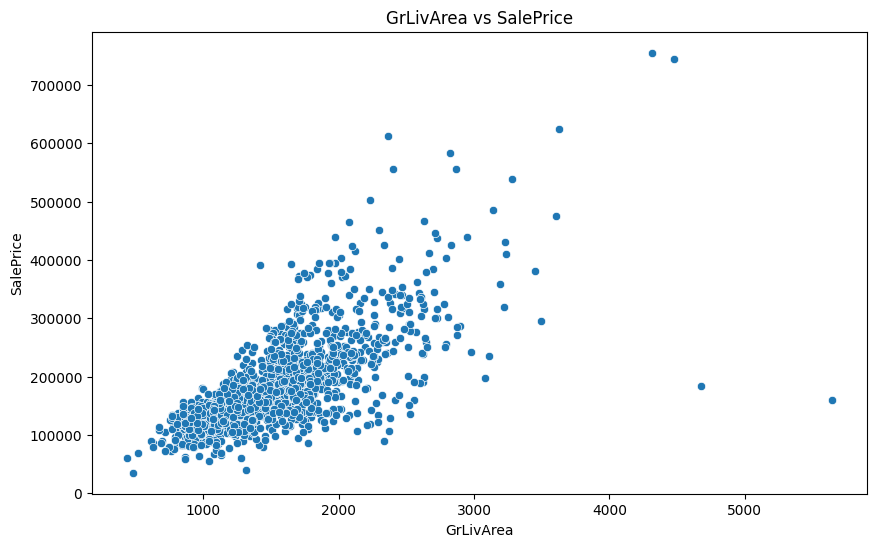

In [13]:

# Scatter plot to detect outliers in GrLivArea
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
plt.title('GrLivArea vs SalePrice')


Here we can see that most of the outliers are beyond 4000 ft for a low saleprice

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

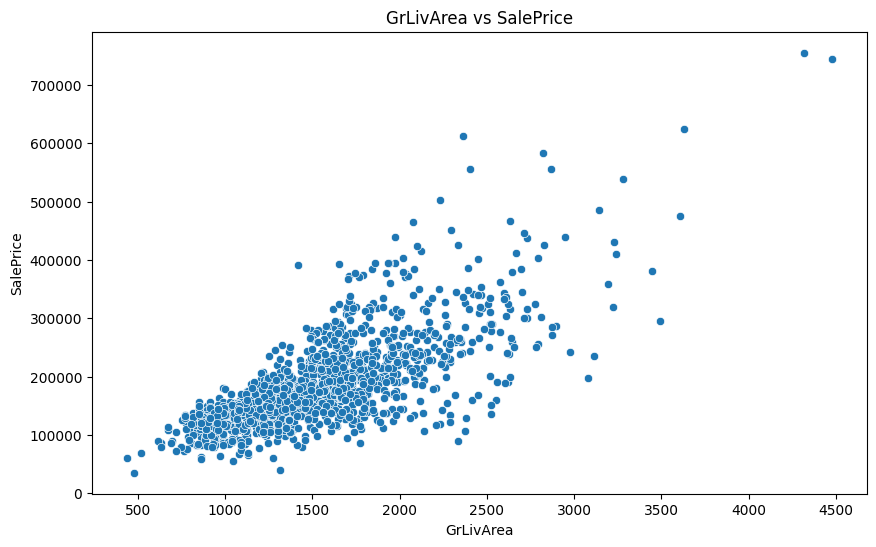

In [14]:
# Remove outliers where GrLivArea > 4000 and SalePrice < 300000
df = df.drop(df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)].index)

# Scatter plot to detect outliers in GrLivArea
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
plt.title('GrLivArea vs SalePrice')


#### GarageArea

<Axes: xlabel='GarageArea', ylabel='SalePrice'>

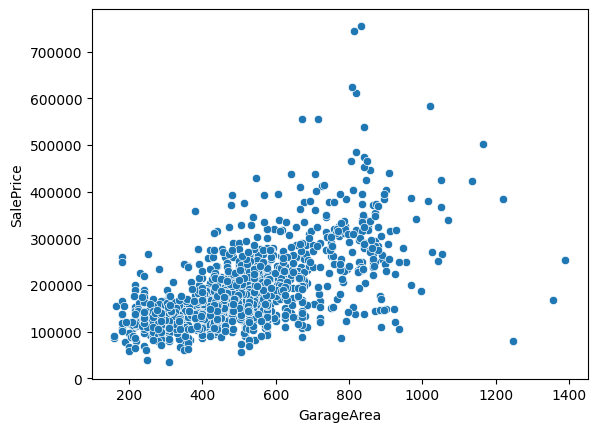

In [15]:
# Scatter plot to check for outliers in GarageArea and SalePrice
sns.scatterplot(x='GarageArea', y='SalePrice', data=df)

In [16]:
# Remove extreme outliers
df = df.drop(df[(df['GarageArea'] > 1200) & (df['SalePrice'] < 300000)].index)

<Axes: xlabel='GarageArea', ylabel='SalePrice'>

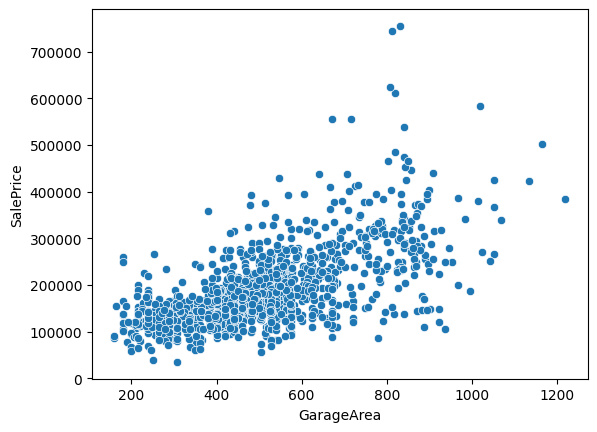

In [17]:
# Scatter plot to check for outliers in GarageArea and SalePrice
sns.scatterplot(x='GarageArea', y='SalePrice', data=df)

#### TotalBsmtSF

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

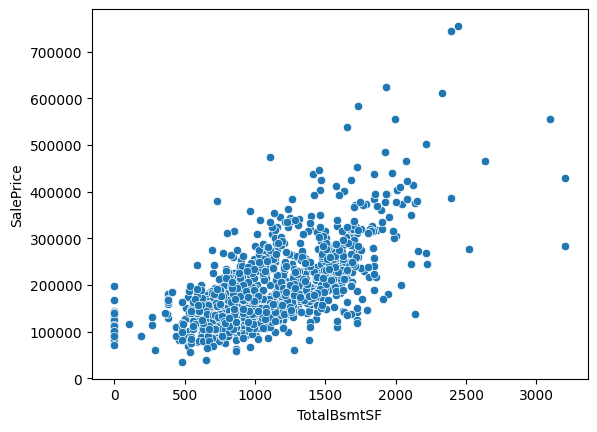

In [18]:
# Scatter plot to check for outliers in TotalBsmtSF and SalePrice
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=df)


In [19]:
# Remove extreme outliers in TotalBsmtSF
df = df.drop(df[(df['TotalBsmtSF'] > 3000) & (df['SalePrice'] < 300000)].index)

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

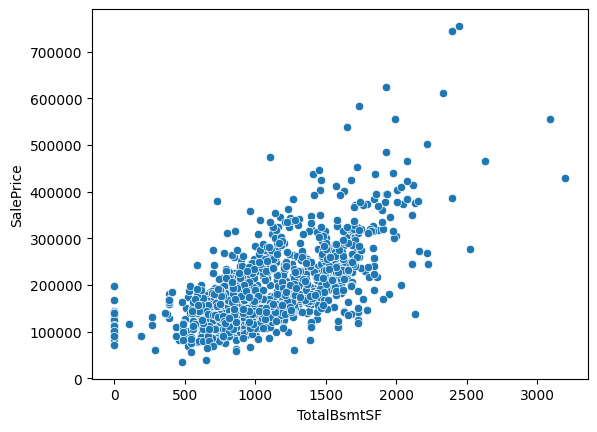

In [20]:
# Scatter plot to check for outliers in TotalBsmtSF and SalePrice
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=df)


#### 1stFlrSF

<Axes: xlabel='1stFlrSF', ylabel='SalePrice'>

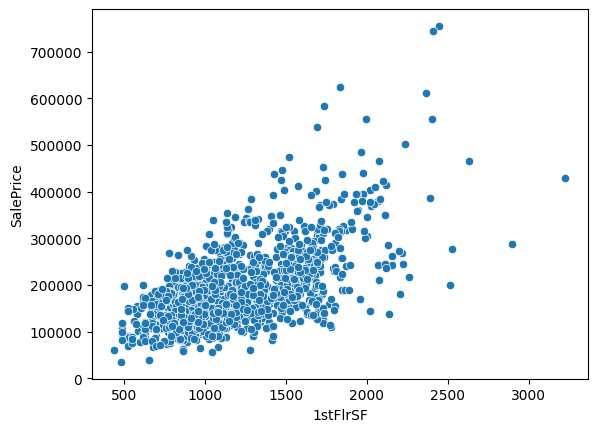

In [21]:
sns.scatterplot(x='1stFlrSF', y='SalePrice', data=df)


### Handle highly skewed features

In [22]:
skewed_features = ['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
                   'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath', 'EnclosedPorch']


#### Plotting the skewed features

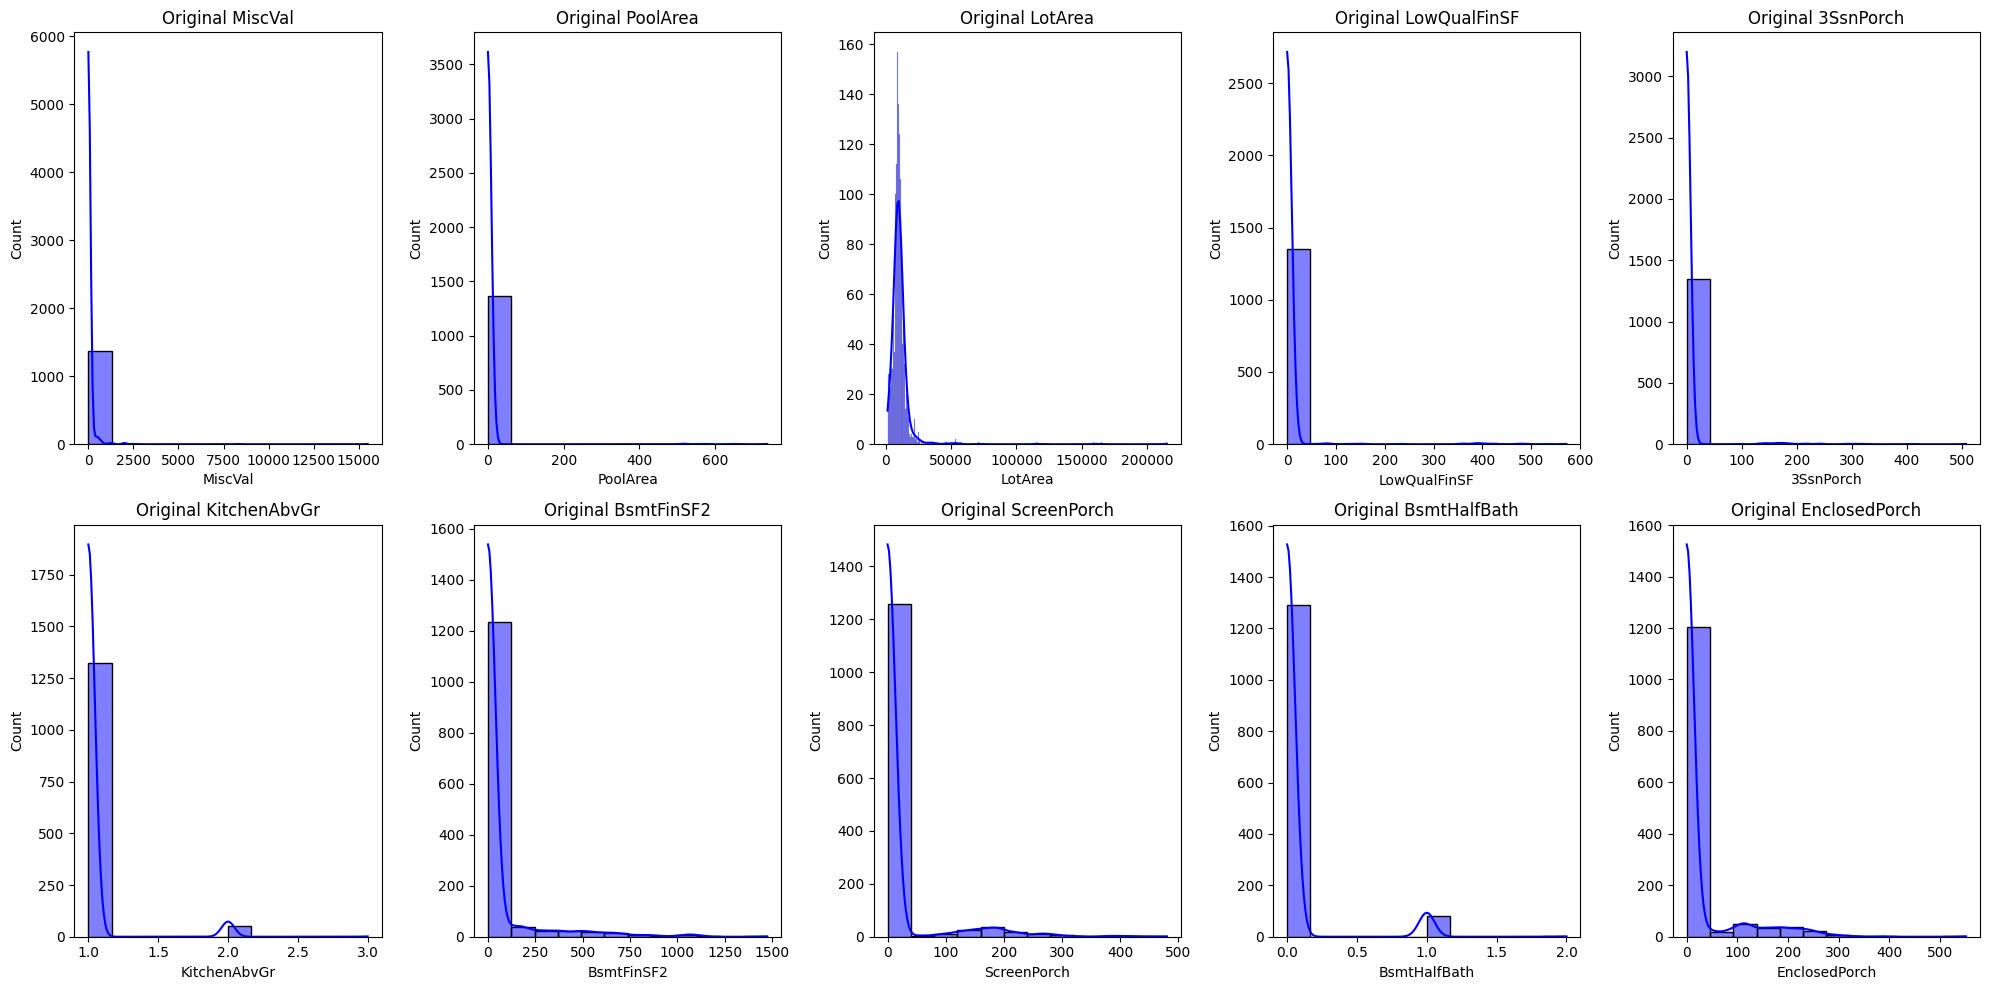

In [23]:
# Set up the plot grid: 2 rows, 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Flatten axes for easier iteration
axes = axes.flatten()

for i, feature in enumerate(skewed_features):
    # Original distribution
    sns.histplot(df[feature], ax=axes[i], kde=True, color='blue')
    axes[i].set_title(f"Original {feature}")
    
plt.tight_layout()
plt.show()

Most of the features are right skewed (most of the distribution is gathered on the left) and some span over a very large x axis domain. 

#### Applying the log1p transformation to the skewed features 

Here we will apply the log1p transformation in order to gather the data within a reasonable range to give less importance to extreme values. This transformation aims also to have a better normality in our data.

In [24]:
# Now, apply the log1p transformation
df[skewed_features] = np.log1p(df[skewed_features])

#### Plotting the features after transformation

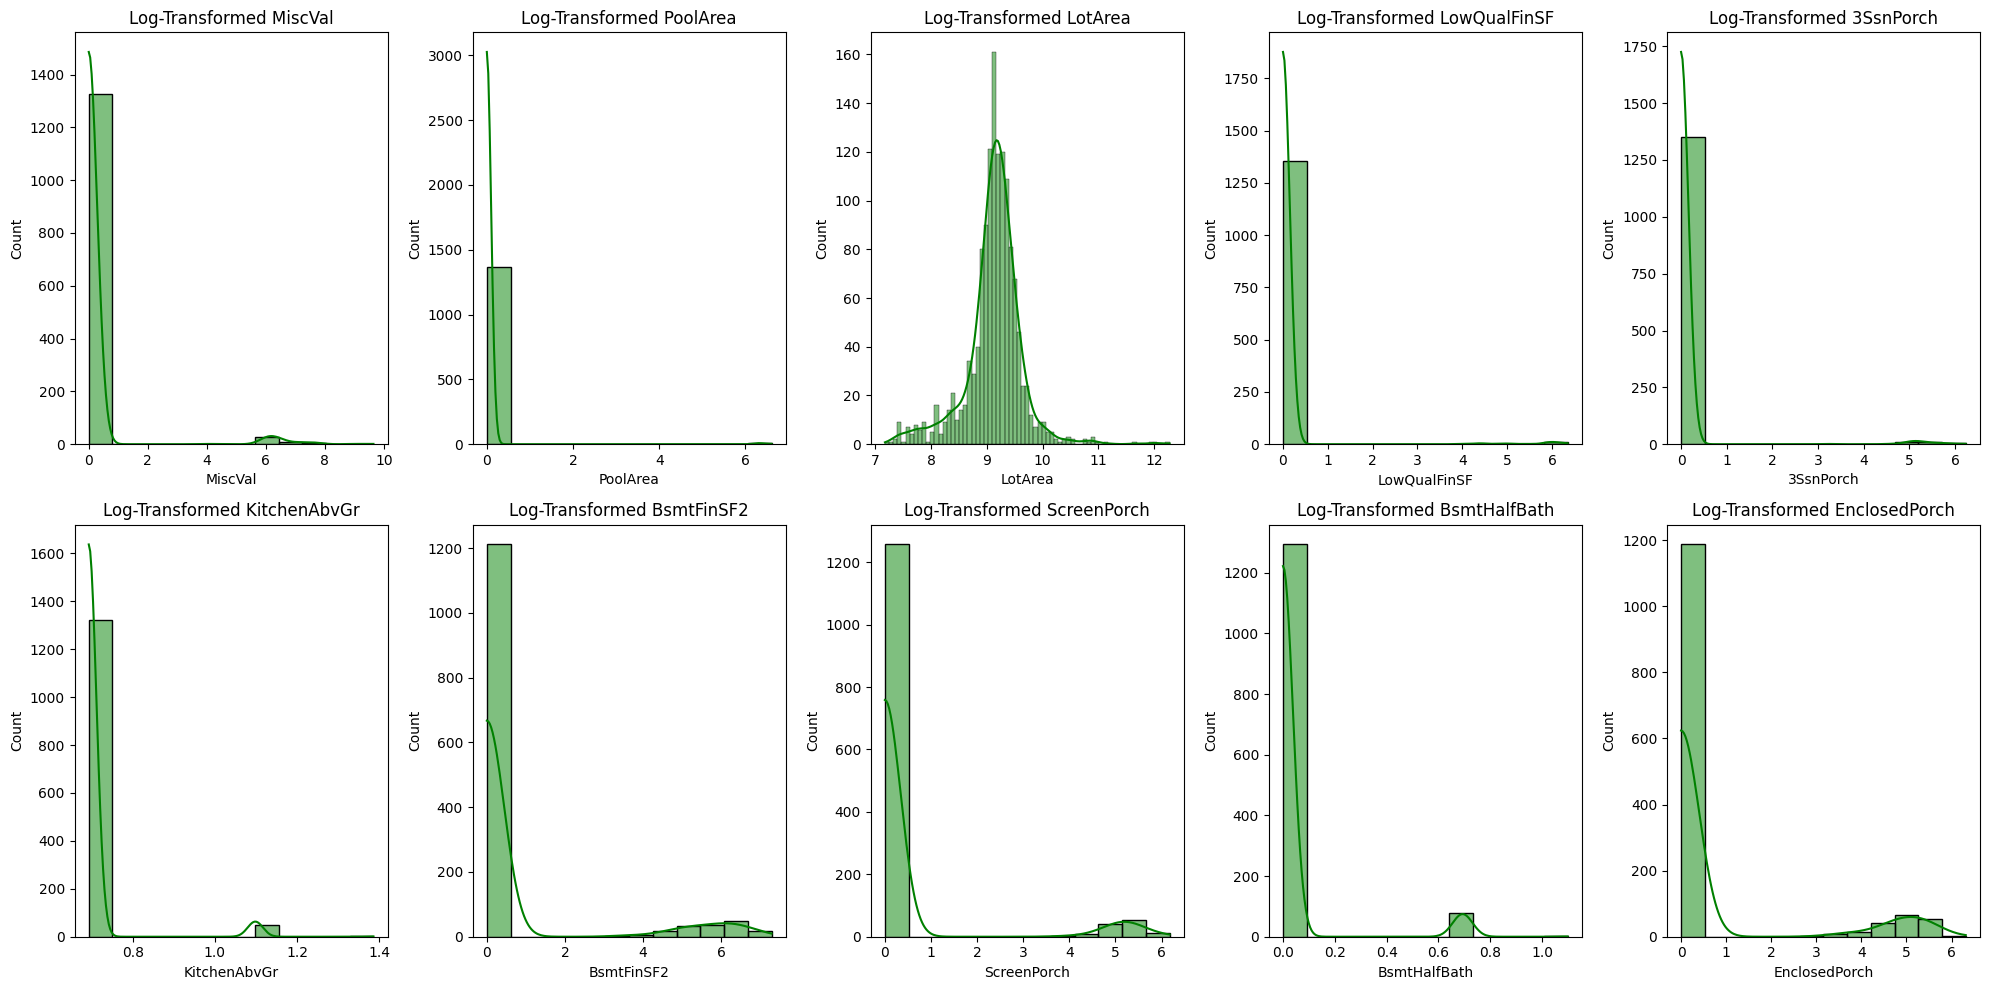

In [25]:
# Plot transformed features
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(skewed_features):
    # Transformed distribution
    sns.histplot(df[feature], ax=axes[i], kde=True, color='green')
    axes[i].set_title(f"Log-Transformed {feature}")

plt.tight_layout()
plt.show()

Most of the data is still right skewed. However the domain now spans on a much more reasonable domaine, extreme values are now being given less importance. Let's note that some features like the LotArea highly benefited from this transformation, now displaying a normal-like distribution.

## Feature Engineering

In this section, we are going to engineer some features for them to make more sense. 

In [26]:

# 1. Create a new feature: HouseAge (difference between YrSold and YearBuilt)
df['HouseAge'] = df['YrSold'] - df['YearBuilt']

# 2. Create a new feature: RemodelAge (difference between YrSold and YearRemodAdd)
df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']

# 3. Create a new feature: TotalBathrooms (FullBath + HalfBath * 0.5)
df['TotalBathrooms'] = df['FullBath'] + (0.5 * df['HalfBath'])

# 4. Create binary feature: HasPool (1 if PoolArea > 0, else 0)
df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# 5. Create binary feature: HasFireplace (1 if Fireplaces > 0, else 0)
df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Drop the original columns that are no longer needed or redundant
df = df.drop(columns=['YearBuilt', 'YearRemodAdd'])  # Drop YearBuilt and YearRemodAdd, already used to create HouseAge and RemodelAge


# Display the first few rows to confirm the new features are created
print(df[['YrSold', 'HouseAge', 'RemodelAge', 'FullBath', 'HalfBath', 'TotalBathrooms', 'PoolArea', 'HasPool', 'Fireplaces', 'HasFireplace']].head())

   YrSold  HouseAge  RemodelAge  FullBath  HalfBath  TotalBathrooms  PoolArea  \
0    2008         5           5         2         1             2.5       0.0   
1    2007        31          31         2         0             2.0       0.0   
2    2008         7           6         2         1             2.5       0.0   
3    2006        91          36         1         0             1.0       0.0   
4    2008         8           8         2         1             2.5       0.0   

   HasPool  Fireplaces  HasFireplace  
0        0           0             0  
1        0           1             1  
2        0           1             1  
3        0           1             1  
4        0           1             1  


## Handling Categorical Variables

Even though some machine learning models can handle categorical variables, we are going to encode ours in order to be able to train several models on our data.

### Identifying the categorical values

In [27]:
# Identify categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns

# Print unique values for each categorical feature
for col in categorical_cols:
    unique_values = df[col].unique()  # Get unique values for the column
    print(f"Feature: {col}")
    print(f"Unique values: {unique_values}")
    print("-" * 40)  # Separator for better readability


Feature: MSZoning
Unique values: ['RL' 'RM' 'C (all)' 'FV' 'RH']
----------------------------------------
Feature: Street
Unique values: ['Pave' 'Grvl']
----------------------------------------
Feature: LotShape
Unique values: ['Reg' 'IR1' 'IR2' 'IR3']
----------------------------------------
Feature: LandContour
Unique values: ['Lvl' 'Bnk' 'Low' 'HLS']
----------------------------------------
Feature: Utilities
Unique values: ['AllPub' 'NoSeWa']
----------------------------------------
Feature: LotConfig
Unique values: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
----------------------------------------
Feature: LandSlope
Unique values: ['Gtl' 'Mod' 'Sev']
----------------------------------------
Feature: Neighborhood
Unique values: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'Edwards' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
-------------

By reading the documentation related to the data, we now can classify our categorical variables into ordinal or nominal variables and therefore later on choose which encoding to proceed with.

In [28]:
# Ordinal Features (with a natural order)
ordinal_features = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 
    'Functional', 'LandSlope', 'Utilities', 'LotShape'
]

# Nominal Features (no natural order)
nominal_features = [
    'MSZoning', 'Street', 'LotConfig', 'Neighborhood', 'Condition1', 
    'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 
    'CentralAir', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition'
]

### Label Encoding for Ordinal Features

In order to keep the natural order of our ordinal features, we are going to use a label encoding.

In [29]:
# Display a few rows of the dataset to confirm encoding
print(df[ordinal_features].head())


  ExterQual ExterCond BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
0        Gd        TA       Gd       TA           No          GLQ   
1        TA        TA       Gd       TA           Gd          ALQ   
2        Gd        TA       Gd       TA           Mn          GLQ   
3        TA        TA       TA       Gd           No          ALQ   
4        Gd        TA       Gd       TA           Av          GLQ   

  BsmtFinType2 HeatingQC KitchenQual FireplaceQu GarageFinish GarageQual  \
0          Unf        Ex          Gd        None          RFn         TA   
1          Unf        Ex          TA          TA          RFn         TA   
2          Unf        Ex          Gd          TA          RFn         TA   
3          Unf        Gd          Gd          Gd          Unf         TA   
4          Unf        Ex          Gd          TA          RFn         TA   

  GarageCond PavedDrive Functional LandSlope Utilities LotShape  
0         TA          Y        Typ       Gtl    AllPub      Re

In [30]:

# Initialize a label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each ordinal feature
for col in ordinal_features:
    # Apply label encoding to ordinal features
    df[col] = label_encoder.fit_transform(df[col])

# Display a few rows of the dataset to confirm encoding
print(df[ordinal_features].head())


   ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  \
0          2          3         2         4             3             2   
1          3          3         2         4             1             0   
2          2          3         2         4             2             2   
3          3          3         4         1             3             0   
4          2          3         2         4             0             2   

   BsmtFinType2  HeatingQC  KitchenQual  FireplaceQu  GarageFinish  \
0             6          0            2            3             1   
1             6          0            3            5             1   
2             6          0            2            5             1   
3             6          2            2            2             2   
4             6          0            2            5             1   

   GarageQual  GarageCond  PavedDrive  Functional  LandSlope  Utilities  \
0           4           4           2           6    

### One-Hot Encoding for Nominal Features

For our nominal features, having no natural order, we will use a One_Hot Encoding to avoid introducing any false hierarchy within these variable. It will increase the dimensionality of our dataset but as we will apply a feature selection later on, it should not cause us any trouble

In [31]:

# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)  # This ensures all columns are printed

# Display all columns in the DataFrame
print(df.columns)

print(df.head())


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'Enclo

In [32]:
# Apply one-hot encoding to nominal features
df = pd.get_dummies(df, columns=nominal_features, drop_first=True)

In [33]:

# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)  # This ensures all columns are printed

# Display all columns in the DataFrame
print(df.columns)

print(df.head())


Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour',
       'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=194)
   Id  MSSubClass  LotFrontage   LotArea  LotShape LandContour  Utilities  \
0   1          60         65.0  9.042040         3         Lvl          0   
1   2          20         80.0  9.169623         3         Lvl          0   
2   3          60         68.0  9.328212         0         Lvl          0   
3   4          70         60.0  9.164401         0         Lvl          0   
4   5          60         84.0  9.565284         0         Lvl          0   

   LandSlope  OverallQual  OverallCond  MasVnrArea  ExterQual  ExterCond  \
0          0            7            5 

The number of features increased up to 194 because of the One-Hot Encoding. Again the feature selection will help us handling a decent number of features later on.

## Scaling features

In order to not harm some ML models needing scaled features we might use, let's go through a scaling step. Let's note that we don't want to scale our saleprice, neither the binary features. An exception are the ordinal features only taking 2 possible values. 

In [34]:

# Detect binary ordinal features (ordinal features with only two unique values)
binary_ordinal_features = df[ordinal_features].columns[df[ordinal_features].nunique() == 2]

# Manually engineered binary features (HasPool, HasFireplace)
engineered_binary_features = ['HasPool', 'HasFireplace']

# List of ordinal features with only 2 unique values that should not be treated as binary
# These should be scaled, not excluded
ordinal_features_with_two_values = list(binary_ordinal_features)

# Identify all columns that are binary (one-hot encoded or manually created binary features)
binary_features = df.columns[df.nunique() == 2]

# Remove the ordinal features with two unique values that should not be treated as binary
binary_features = binary_features.difference(ordinal_features_with_two_values)

# Combine manually created binary features with detected binary features
binary_features = binary_features.union(engineered_binary_features)

# Identify numerical features (excluding 'SalePrice' and binary features)
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.difference(binary_features.union(['SalePrice']))

# Initialize the scaler
scaler = StandardScaler()

# Scale only the numerical and ordinal features (ordinal features are now part of numerical_features)
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Display the first few rows to confirm scaling
print(df[numerical_features].head())


   1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  \
0 -0.852036  1.142223    -0.1326      0.171646  0.316055      0.603867   
1  0.242444 -0.805411    -0.1326      0.171646  0.316055     -1.109168   
2 -0.679507  1.169590    -0.1326      0.171646  0.316055     -0.252651   
3 -0.568981  0.918724    -0.1326      0.171646 -2.922332      0.603867   
4 -0.072960  1.596062    -0.1326      1.445534  0.316055     -1.965686   

   BsmtFinSF1  BsmtFinSF2  BsmtFinType1  BsmtFinType2  BsmtFullBath  \
0    0.588370   -0.361526     -0.495133      0.343739      1.114635   
1    1.213881   -0.361526     -1.386696      0.343739     -0.837398   
2    0.082443   -0.361526     -0.495133      0.343739      1.114635   
3   -0.538468   -0.361526     -1.386696      0.343739      1.114635   
4    0.471087   -0.361526     -0.495133      0.343739      1.114635   

   BsmtHalfBath  BsmtQual  BsmtUnfSF  EnclosedPorch  ExterCond  ExterQual  \
0     -0.248192 -0.539191  -0.948910      -0.392626

We can now check our features being on the same scale, with some negative values. Indeed the scale we chose is setting the mean as 0 and the deviation as 1. All the values lower than the mean are therefore being negative with this scale.

# 4. Feature Selection

In order to avoid the curse of dimensionality and overfitting, we will select the most relevant features to train our models.

### Correlation-Based Feature Selection

Let's have a look at the correlation and make a first selection based on this indicator.

In [35]:

# Compute the correlation matrix
correlation_matrix = df.corr()

# Get correlations with SalePrice
corr_with_saleprice = correlation_matrix['SalePrice'].sort_values(ascending=False)

# Display the correlations
print(corr_with_saleprice)



SalePrice       1.000000
OverallQual     0.792591
GrLivArea       0.736982
TotalBsmtSF     0.646030
GarageCars      0.643368
                  ...   
HouseAge       -0.507540
GarageFinish   -0.515566
BsmtQual       -0.598965
KitchenQual    -0.624200
ExterQual      -0.666918
Name: SalePrice, Length: 193, dtype: float64


/var/folders/mq/1ld9t8tj6577mpr_yq29l3sw0000gn/T/ipykernel_17329/3959671195.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


We have both positive and negative highly correlated features with the target variables. Let's set a threshold to only keep the most correlated features.

In [36]:
# Set a threshold for the absolute value of correlation
threshold = 0.3

# Filter features with absolute correlation above the threshold
strong_corr_features = corr_with_saleprice[abs(corr_with_saleprice) >= threshold].index

# Display the selected features and their correlations
print("Selected Features (Correlation >= 0.3):\n", corr_with_saleprice[strong_corr_features])

# Remove 'SalePrice' from the selected features list since it's the target variable
strong_corr_features = strong_corr_features.drop('SalePrice')

# Display the number of features left after filtering
print(f"\nNumber of features remaining after applying the threshold: {len(strong_corr_features)}")


Selected Features (Correlation >= 0.3):
 SalePrice                1.000000
OverallQual              0.792591
GrLivArea                0.736982
TotalBsmtSF              0.646030
GarageCars               0.643368
GarageArea               0.632104
1stFlrSF                 0.621927
TotalBathrooms           0.592008
FullBath                 0.557408
TotRmsAbvGrd             0.542935
Foundation_PConc         0.490851
GarageYrBlt              0.487310
MasVnrArea               0.467597
HasFireplace             0.451500
Fireplaces               0.451262
Neighborhood_NridgHt     0.401629
BsmtFinSF1               0.399689
LotArea                  0.379137
LotFrontage              0.365867
SaleType_New             0.362540
SaleCondition_Partial    0.356343
OpenPorchSF              0.339917
Neighborhood_NoRidge     0.332544
MasVnrType_Stone         0.329862
2ndFlrSF                 0.315820
WoodDeckSF               0.315422
Exterior2nd_VinylSd      0.303116
Exterior1st_VinylSd      0.301309
BsmtExp

We are left with 38 features.

In [37]:
# Get the number of samples (rows) in the DataFrame
num_samples = df.shape[0]

# Print the number of samples
print(f"Number of samples: {num_samples}")


Number of samples: 1373


The 10:1 Sample-to-Feature Ratio rule of thumb is respected to avoid overfitting. We can stop our feature selection here.


# 5. Model Building

## Splitting the Data

In [38]:

# Separate features (X) and target (y)
X = df[strong_corr_features]  # Features from feature selection
y = df['SalePrice']  # Target variable

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the sizes of the split data
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_valid.shape[0]} samples")


Training set size: 1098 samples
Validation set size: 275 samples


## Training Multiple Models

In [39]:
# Compute the mean house price
mean_house_price = df['SalePrice'].mean()

# Display the mean house price
print(f"Mean House Price: ${mean_house_price:,.2f}")


Mean House Price: $185,466.28


### Linear Regression

In [40]:

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_lr = lr_model.predict(X_valid)

# Evaluate the model
mse_lr = mean_squared_error(y_valid, y_pred_lr)  # MSE
rmse_lr = mse_lr ** 0.5  # RMSE is the square root of MSE
mae_lr = mean_absolute_error(y_valid, y_pred_lr)  # MAE
r2_lr = r2_score(y_valid, y_pred_lr)  # R²

# Display the results
print(f"Linear Regression - RMSE: {rmse_lr:.2f}, MAE: {mae_lr:.2f}, R²: {r2_lr:.2f}")


Linear Regression - RMSE: 30398.03, MAE: 19395.53, R²: 0.87


#### Tuning Linear Regression

In [58]:

# Define parameter grids for Ridge and Lasso
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Ridge Regression tuning
ridge_model = Ridge()
ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Lasso Regression tuning
lasso_model = Lasso(max_iter=10000)
lasso_grid = GridSearchCV(lasso_model, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

# Best Ridge and Lasso Models
best_ridge = ridge_grid.best_estimator_
best_lasso = lasso_grid.best_estimator_

# Make predictions on the validation set using the best Ridge model
y_pred_ridge = best_ridge.predict(X_valid)
mse_ridge = mean_squared_error(y_valid, y_pred_ridge)
rmse_ridge = mse_ridge ** 0.5
mae_ridge = mean_absolute_error(y_valid, y_pred_ridge)
r2_ridge = r2_score(y_valid, y_pred_ridge)

print(f"Tuned Ridge Regression - RMSE: {rmse_ridge:.2f}, MAE: {mae_ridge:.2f}, R²: {r2_ridge:.2f}")

# Make predictions on the validation set using the best Lasso model
y_pred_lasso = best_lasso.predict(X_valid)
mse_lasso = mean_squared_error(y_valid, y_pred_lasso)
rmse_lasso = mse_lasso ** 0.5
mae_lasso = mean_absolute_error(y_valid, y_pred_lasso)
r2_lasso = r2_score(y_valid, y_pred_lasso)

print(f"Tuned Lasso Regression - RMSE: {rmse_lasso:.2f}, MAE: {mae_lasso:.2f}, R²: {r2_lasso:.2f}")

# Display the best alpha values
print(f"Best alpha for Ridge: {ridge_grid.best_params_['alpha']}")
print(f"Best alpha for Lasso: {lasso_grid.best_params_['alpha']}")


Tuned Ridge Regression - RMSE: 30268.89, MAE: 19183.92, R²: 0.87
Tuned Lasso Regression - RMSE: 30268.19, MAE: 19318.46, R²: 0.87
Best alpha for Ridge: 10
Best alpha for Lasso: 100


### Random Forest 

In [41]:

# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_valid)

# Evaluate the model using RMSE, MAE, and R²
mse_rf = mean_squared_error(y_valid, y_pred_rf)  # MSE
rmse_rf = mse_rf ** 0.5  # RMSE is the square root of MSE
mae_rf = mean_absolute_error(y_valid, y_pred_rf)  # MAE
r2_rf = r2_score(y_valid, y_pred_rf)  # R²

# Display the results
print(f"Random Forest - RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")


Random Forest - RMSE: 29681.64, MAE: 18934.06, R²: 0.87


#### Tuning the Random Forest

In [42]:

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],          # Number of trees
    'max_depth': [None, 10, 20, 30],          # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],            # Minimum number of samples required at each leaf node
    'max_features': ['auto', 'sqrt', 'log2']   # Number of features to consider at each split
}

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Display the best parameters from the search
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
best_rf_model = grid_search.best_estimator_

# Make predictions on the validation set
y_pred_rf_tuned = best_rf_model.predict(X_valid)

# Evaluate the tuned model
mse_rf_tuned = mean_squared_error(y_valid, y_pred_rf_tuned)
rmse_rf_tuned = mse_rf_tuned ** 0.5  # RMSE
mae_rf_tuned = mean_absolute_error(y_valid, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_valid, y_pred_rf_tuned)

# Display the results
print(f"Tuned Random Forest - RMSE: {rmse_rf_tuned:.2f}, MAE: {mae_rf_tuned:.2f}, R²: {r2_rf_tuned:.2f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_sp

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=None,

[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto

[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=20, max_features=auto

/Users/noeflandre/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
63 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/noeflandre/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/noeflandre/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/noeflandre/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_const

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Tuned Random Forest - RMSE: 31051.20, MAE: 18734.83, R²: 0.86


### XGBoost

In [43]:

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Train the XGBoost model on the training set
xgb_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_xgb = xgb_model.predict(X_valid)

# Evaluate the XGBoost model using RMSE, MAE, and R²
mse_xgb = mean_squared_error(y_valid, y_pred_xgb)  # MSE
rmse_xgb = mse_xgb ** 0.5  # RMSE
mae_xgb = mean_absolute_error(y_valid, y_pred_xgb)
r2_xgb = r2_score(y_valid, y_pred_xgb)

# Display the results
print(f"XGBoost - RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}, R²: {r2_xgb:.2f}")


XGBoost - RMSE: 29356.77, MAE: 18809.80, R²: 0.88


#### Tuning XGBoost

In [44]:

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],          # Number of trees
    'max_depth': [3, 5, 7],                   # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2],        # Learning rate (eta)
    'subsample': [0.6, 0.8, 1.0],             # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],      # Subsample ratio of columns (features)
    'gamma': [0, 0.1, 0.3]                    # Minimum loss reduction to make a split
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Display the best parameters from the search
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
best_xgb_model = grid_search.best_estimator_

# Make predictions on the validation set
y_pred_xgb_tuned = best_xgb_model.predict(X_valid)

# Evaluate the tuned model
mse_xgb_tuned = mean_squared_error(y_valid, y_pred_xgb_tuned)
rmse_xgb_tuned = mse_xgb_tuned ** 0.5  # RMSE
mae_xgb_tuned = mean_absolute_error(y_valid, y_pred_xgb_tuned)
r2_xgb_tuned = r2_score(y_valid, y_pred_xgb_tuned)

# Display the results
print(f"Tuned XGBoost - RMSE: {rmse_xgb_tuned:.2f}, MAE: {mae_xgb_tuned:.2f}, R²: {r2_xgb_tuned:.2f}")


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None,

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_dept

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=None

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=N

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=log2

[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=auto

[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=s

[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END max_depth=30, max_features=sqr

[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqr

[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=lo

[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=log2

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; tot

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=

[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; tot

[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; tot

[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6; total ti

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.6; total ti

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.6s
[CV] END

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; tot

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time

Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Tuned XGBoost - RMSE: 25697.76, MAE: 16663.51, R²: 0.90


### Gradient Boosting Regressor

In [45]:

# Initialize the Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=42)

# Train the model
gbr_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_gbr = gbr_model.predict(X_valid)

# Evaluate the model using RMSE, MAE, and R²
mse_gbr = mean_squared_error(y_valid, y_pred_gbr)
rmse_gbr = mse_gbr ** 0.5  # RMSE
mae_gbr = mean_absolute_error(y_valid, y_pred_gbr)
r2_gbr = r2_score(y_valid, y_pred_gbr)

# Display the results
print(f"Gradient Boosting - RMSE: {rmse_gbr:.2f}, MAE: {mae_gbr:.2f}, R²: {r2_gbr:.2f}")


Gradient Boosting - RMSE: 26299.18, MAE: 17052.61, R²: 0.90


#### Tuning GBR

In [46]:

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],          # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],        # Learning rate
    'max_depth': [3, 5, 7],                   # Maximum depth of trees
    'min_samples_split': [2, 5, 10],          # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],            # Minimum samples required at a leaf node
    'subsample': [0.6, 0.8, 1.0],             # Fraction of samples used for training each tree
    'max_features': ['auto', 'sqrt', 'log2']   # Number of features considered for best split
}

# Initialize the Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Display the best parameters from the search
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
best_gbr_model = grid_search.best_estimator_

# Make predictions on the validation set
y_pred_gbr_tuned = best_gbr_model.predict(X_valid)

# Evaluate the tuned model
mse_gbr_tuned = mean_squared_error(y_valid, y_pred_gbr_tuned)
rmse_gbr_tuned = mse_gbr_tuned ** 0.5  # RMSE
mae_gbr_tuned = mean_absolute_error(y_valid, y_pred_gbr_tuned)
r2_gbr_tuned = r2_score(y_valid, y_pred_gbr_tuned)

# Display the results
print(f"Tuned Gradient Boosting - RMSE: {rmse_gbr_tuned:.2f}, MAE: {mae_gbr_tuned:.2f}, R²: {r2_gbr_tuned:.2f}")


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.3, lea

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=

[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_l

[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0; total time=

[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_lea

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.6; total time=

[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_l

[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_lea

[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_sample

[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_sampl

[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_sample

[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_lea

[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_sampl

[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_le

[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_lea

[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, max_features=auto, min_samples

[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_sampl

[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_l

[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_lea

[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_sampl

[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_lea

[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, max_features=log2, min_samples_lea

[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_lea

[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_lea

[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=7, max_features=auto, min_sampl

[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=log2, min_samples_l

[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_lea

[CV] END learning_rate=0.01, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=7, max_features=log2, min_samples_

[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=1, mi

[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_lea

[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, max_features=sqrt, min_sampl

[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, mi

[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf

[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf

[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, max_features=auto, min_samples_leaf=4, mi

[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=sqrt, min_samples_leaf=1, 

[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf

[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=2, mi

[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=auto, min_samples_leaf=

[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=4,

[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=4, mi

[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, max_features=log2, min_samples_leaf=4, mi

[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=1,

[CV] END learning_rate=0.1, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, max_features=auto, min_samples_leaf=2, 

[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=2, mi

[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4,

[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4,

[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4,

[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=

[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=2, mi

[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=log2, min_samples_leaf=4, mi

[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf

[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, mi

[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=1, mi

[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=sqrt, min_samples_leaf=2

[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=2

[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=4, mi

[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=7, max_features=log2, min_samples_leaf=2, mi

[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, max_features=auto, min_samples_leaf=4, mi

[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf

[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=2, mi

[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=1, mi

[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, max_features=sqrt, min_samples_leaf=4, 

[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, max_features=log2, min_samples_leaf=1, mi

[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=2, mi

[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf

[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=4, mi

[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, mi

[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, m

[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=1, m

[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=7, max_features=auto, min_samples_leaf=1, mi

[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf

[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, max_features=log2, min_samples_leaf=2, mi

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.6}
Tuned Gradient Boosting - RMSE: 25269.81, MAE: 16386.60, R²: 0.91


/Users/noeflandre/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
3645 fits failed out of a total of 10935.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
390 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/noeflandre/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/noeflandre/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/noeflandre/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_co

### Neural Network

In [47]:

# Initialize the neural network
model = Sequential()

# Input layer and first hidden layer with 64 neurons and ReLU activation
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Second hidden layer with 32 neurons and ReLU activation
model.add(Dense(32, activation='relu'))

# Output layer with 1 neuron (since this is regression)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the neural network
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                    epochs=100, batch_size=32, verbose=1)

# Make predictions on the validation set
y_pred_nn = model.predict(X_valid).flatten()

# Evaluate the model using RMSE, MAE, and R²
mse_nn = mean_squared_error(y_valid, y_pred_nn)
rmse_nn = mse_nn ** 0.5  # RMSE
mae_nn = mean_absolute_error(y_valid, y_pred_nn)
r2_nn = r2_score(y_valid, y_pred_nn)

# Display the results
print(f"Neural Network - RMSE: {rmse_nn:.2f}, MAE: {mae_nn:.2f}, R²: {r2_nn:.2f}")


Epoch 1/100


2024-09-22 10:49:42.641715: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


35/35 [==============================] - 0s 5ms/step - loss: 40033640448.0000 - val_loss: 43088429056.0000
Epoch 2/100
35/35 [==============================] - 0s 991us/step - loss: 40031338496.0000 - val_loss: 43084128256.0000
Epoch 3/100
35/35 [==============================] - 0s 658us/step - loss: 40023990272.0000 - val_loss: 43071262720.0000
Epoch 4/100
35/35 [==============================] - 0s 619us/step - loss: 40005468160.0000 - val_loss: 43042357248.0000
Epoch 5/100
35/35 [==============================] - 0s 625us/step - loss: 39966556160.0000 - val_loss: 42986541056.0000
Epoch 6/100
35/35 [==============================] - 0s 635us/step - loss: 39897841664.0000 - val_loss: 42895249408.0000
Epoch 7/100
35/35 [==============================] - 0s 612us/step - loss: 39791583232.0000 - val_loss: 42755117056.0000
Epoch 8/100
35/35 [==============================] - 0s 642us/step - loss: 39635529728.0000 - val_loss: 42558410752.0000
Epoch 9/100
35/35 [===========================

Epoch 69/100
35/35 [==============================] - 0s 596us/step - loss: 3062877952.0000 - val_loss: 3667196928.0000
Epoch 70/100
35/35 [==============================] - 0s 607us/step - loss: 3018849280.0000 - val_loss: 3622908672.0000
Epoch 71/100
35/35 [==============================] - 0s 555us/step - loss: 2975832064.0000 - val_loss: 3580526336.0000
Epoch 72/100
35/35 [==============================] - 0s 558us/step - loss: 2933850624.0000 - val_loss: 3541054208.0000
Epoch 73/100
35/35 [==============================] - 0s 589us/step - loss: 2894311936.0000 - val_loss: 3500259584.0000
Epoch 74/100
35/35 [==============================] - 0s 577us/step - loss: 2854385152.0000 - val_loss: 3461156864.0000
Epoch 75/100
35/35 [==============================] - 0s 563us/step - loss: 2815887360.0000 - val_loss: 3424087808.0000
Epoch 76/100
35/35 [==============================] - 0s 557us/step - loss: 2777912576.0000 - val_loss: 3385644032.0000
Epoch 77/100
35/35 [====================

#### Tuning ANN

In [48]:

# Define the neural network model
model = Sequential()

# Add layers (with Dropout)
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))  # Dropout layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Dropout layer
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                    epochs=200, batch_size=64, callbacks=[early_stopping], verbose=1)

# Make predictions on the validation set
y_pred_nn_tuned = model.predict(X_valid).flatten()

# Evaluate the model using RMSE, MAE, and R²
mse_nn_tuned = mean_squared_error(y_valid, y_pred_nn_tuned)
rmse_nn_tuned = mse_nn_tuned ** 0.5  # RMSE
mae_nn_tuned = mean_absolute_error(y_valid, y_pred_nn_tuned)
r2_nn_tuned = r2_score(y_valid, y_pred_nn_tuned)

# Display the results
print(f"Tuned Neural Network - RMSE: {rmse_nn_tuned:.2f}, MAE: {mae_nn_tuned:.2f}, R²: {r2_nn_tuned:.2f}")


Epoch 1/200
18/18 [==============================] - 0s 3ms/step - loss: 40033300480.0000 - val_loss: 43087659008.0000
Epoch 2/200
18/18 [==============================] - 0s 955us/step - loss: 40029409280.0000 - val_loss: 43079544832.0000
Epoch 3/200
18/18 [==============================] - 0s 941us/step - loss: 40014462976.0000 - val_loss: 43048329216.0000
Epoch 4/200
18/18 [==============================] - 0s 1ms/step - loss: 39962554368.0000 - val_loss: 42956369920.0000
Epoch 5/200
18/18 [==============================] - 0s 1ms/step - loss: 39827787776.0000 - val_loss: 42734514176.0000
Epoch 6/200
18/18 [==============================] - 0s 1ms/step - loss: 39529369600.0000 - val_loss: 42274783232.0000
Epoch 7/200
18/18 [==============================] - 0s 1ms/step - loss: 38939144192.0000 - val_loss: 41442750464.0000
Epoch 8/200
18/18 [==============================] - 0s 1ms/step - loss: 37976571904.0000 - val_loss: 40085155840.0000
Epoch 9/200
18/18 [=========================

18/18 [==============================] - 0s 1ms/step - loss: 1673611392.0000 - val_loss: 1606091648.0000
Epoch 71/200
18/18 [==============================] - 0s 1ms/step - loss: 1648921472.0000 - val_loss: 1575919872.0000
Epoch 72/200
18/18 [==============================] - 0s 1ms/step - loss: 1642825344.0000 - val_loss: 1558336128.0000
Epoch 73/200
18/18 [==============================] - 0s 1ms/step - loss: 1640947200.0000 - val_loss: 1536171776.0000
Epoch 74/200
18/18 [==============================] - 0s 1ms/step - loss: 1626772480.0000 - val_loss: 1506920576.0000
Epoch 75/200
18/18 [==============================] - 0s 1ms/step - loss: 1567558272.0000 - val_loss: 1487418240.0000
Epoch 76/200
18/18 [==============================] - 0s 1ms/step - loss: 1483193344.0000 - val_loss: 1494536832.0000
Epoch 77/200
18/18 [==============================] - 0s 996us/step - loss: 1431087232.0000 - val_loss: 1494912512.0000
Epoch 78/200
18/18 [==============================] - 0s 1ms/step -

Epoch 139/200
18/18 [==============================] - 0s 1ms/step - loss: 1031276672.0000 - val_loss: 1003885120.0000
Epoch 140/200
18/18 [==============================] - 0s 1ms/step - loss: 1216402560.0000 - val_loss: 991747264.0000
Epoch 141/200
18/18 [==============================] - 0s 1ms/step - loss: 1154398848.0000 - val_loss: 982887040.0000
Epoch 142/200
18/18 [==============================] - 0s 1ms/step - loss: 1195352320.0000 - val_loss: 989207232.0000
Epoch 143/200
18/18 [==============================] - 0s 1ms/step - loss: 1218369280.0000 - val_loss: 1002903744.0000
Epoch 144/200
18/18 [==============================] - 0s 1ms/step - loss: 1209936256.0000 - val_loss: 975055488.0000
Epoch 145/200
18/18 [==============================] - 0s 1ms/step - loss: 1217858560.0000 - val_loss: 987128768.0000
Epoch 146/200
18/18 [==============================] - 0s 1ms/step - loss: 1285143680.0000 - val_loss: 978607680.0000
Epoch 147/200
18/18 [==============================] -

### Support Vector Regression

In [52]:
# Initialize the Support Vector Regressor model with an RBF kernel
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

# Train the model on the training set
svr_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_svr = svr_model.predict(X_valid)

# Evaluate the model using RMSE, MAE, and R²
mse_svr = mean_squared_error(y_valid, y_pred_svr)
rmse_svr = mse_svr ** 0.5  # RMSE
mae_svr = mean_absolute_error(y_valid, y_pred_svr)
r2_svr = r2_score(y_valid, y_pred_svr)

# Display the results
print(f"SVR - RMSE: {rmse_svr:.2f}, MAE: {mae_svr:.2f}, R²: {r2_svr:.2f}")


SVR - RMSE: 85411.71, MAE: 54489.82, R²: -0.05


#### Tuning SVR 

In [53]:
# Define the parameter grid for tuning SVR
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Kernel coefficient
    'epsilon': [0.1, 0.2, 0.5]  # Epsilon in the epsilon-SVR loss function
}

# Initialize GridSearchCV with SVR and 5-fold cross-validation
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Output the best parameters from the grid search
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
best_svr_model = grid_search.best_estimator_
y_pred_best_svr = best_svr_model.predict(X_valid)

# Evaluate the tuned model using RMSE, MAE, and R²
mse_best_svr = mean_squared_error(y_valid, y_pred_best_svr)
rmse_best_svr = mse_best_svr ** 0.5  # RMSE
mae_best_svr = mean_absolute_error(y_valid, y_pred_best_svr)
r2_best_svr = r2_score(y_valid, y_pred_best_svr)

# Display the tuned SVR results
print(f"Tuned SVR - RMSE: {rmse_best_svr:.2f}, MAE: {mae_best_svr:.2f}, R²: {r2_best_svr:.2f}")

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best Parameters: {'C': 1000, 'epsilon': 0.5, 'gamma': 0.01}
Tuned SVR - RMSE: 57806.56, MAE: 29250.05, R²: 0.52


### K-Nearest Neighbors

In [55]:
# Initialize the K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor(n_neighbors=5)  # n_neighbors=5 

# Train the KNN model
knn_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_knn = knn_model.predict(X_valid)

# Evaluate the KNN model using RMSE, MAE, and R²
mse_knn = mean_squared_error(y_valid, y_pred_knn)
rmse_knn = mse_knn ** 0.5  # RMSE
mae_knn = mean_absolute_error(y_valid, y_pred_knn)
r2_knn = r2_score(y_valid, y_pred_knn)

# Display the results
print(f"KNN Regression - RMSE: {rmse_knn:.2f}, MAE: {mae_knn:.2f}, R²: {r2_knn:.2f}")

KNN Regression - RMSE: 35795.12, MAE: 22374.56, R²: 0.82


#### Tuning KNN

In [56]:
# Define the parameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],  # Number of neighbors
    'weights': ['uniform', 'distance'],    # Weighting of neighbors
    'p': [1, 2]                            # 1: Manhattan, 2: Euclidean distance
}

# Initialize GridSearchCV with the KNN regressor
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Output the best parameters from the grid search
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator from the grid search
best_knn_model = grid_search.best_estimator_

# Make predictions on the validation set
y_pred_best_knn = best_knn_model.predict(X_valid)

# Evaluate the tuned model using RMSE, MAE, and R²
mse_best_knn = mean_squared_error(y_valid, y_pred_best_knn)
rmse_best_knn = mse_best_knn ** 0.5  # RMSE
mae_best_knn = mean_absolute_error(y_valid, y_pred_best_knn)
r2_best_knn = r2_score(y_valid, y_pred_best_knn)

# Display the results
print(f"Tuned KNN Regression - RMSE: {rmse_best_knn:.2f}, MAE: {mae_best_knn:.2f}, R²: {r2_best_knn:.2f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Tuned KNN Regression - RMSE: 35026.51, MAE: 20878.58, R²: 0.82


# 6. Conclusion 


Throughout the project, we implemented and tuned several machine learning models to predict house prices based on the given dataset. Each model showed varying performance levels, and the results were assessed using three key metrics: **RMSE (Root Mean Squared Error)**, **MAE (Mean Absolute Error)**, and **R² (Coefficient of Determination)**. These metrics helped us determine the models' ability to generalize and capture the underlying relationships in the data.

**Observations**:
1. **Gradient Boosting** provided the best overall performance, with an **R²** score of 0.91 and the lowest **RMSE** and **MAE** after tuning, indicating it captures the complex relationships in the data effectively.
2. **XGBoost** also performed well, especially after tuning, with an **R²** of 0.90. This model is robust and efficient for tabular data.
3. **Neural Networks** performed decently after tuning, but initially, they struggled with high RMSE and MAE, indicating the need for careful tuning and proper architecture.
4. **KNN and SVR** did not perform as well as the tree-based models, especially the SVR, which had poor results even after tuning.
5. **Random Forest** showed strong performance, especially after tuning, but it was outperformed by Gradient Boosting and XGBoost.
6. **Ridge** and **Lasso Regression**, while simple, performed reasonably well after tuning with **R²** scores of 0.87, showcasing the effectiveness of regularization techniques in linear models.
7. **Linear Regression**, while simple, performed decently and showed improvements after tuning through regularization.

### Mean House Price

The **mean house price** in the dataset is **$185,466.28**, which serves as a benchmark to evaluate the error metrics (RMSE and MAE). A good model should have lower error values relative to this mean.

### Performance Results Table

| **Model**                     | **RMSE**    | **MAE**     | **R²**  | **Tuned RMSE** | **Tuned MAE** | **Tuned R²** |
|-------------------------------|-------------|-------------|---------|----------------|---------------|--------------|
| **KNN Regression**             | 35,795.12   | 22,374.56   | 0.82    | 35,026.51      | 20,878.58     | 0.82         |
| **SVR**                        | 85,411.71   | 54,489.82   | -0.05   | 57,806.56      | 29,250.05     | 0.52         |
| **Neural Network**             | 51,666.49   | 42,506.37   | 0.62    | 29,729.76      | 20,700.46     | 0.87         |
| **Gradient Boosting**          | 26,299.18   | 17,052.61   | 0.90    | 25,269.81      | 16,386.60     | 0.91         |
| **XGBoost**                    | 29,356.77   | 18,809.80   | 0.88    | 25,697.76      | 16,663.51     | 0.90         |
| **Random Forest**              | 29,681.64   | 18,934.06   | 0.87    | 31,051.20      | 18,734.83     | 0.86         |
| **Linear Regression**          | 30,398.03   | 19,395.53   | 0.87    | -              | -             | -            |
| **Tuned Ridge Regression**     | -           | -           | -       | 30,268.89      | 19,183.92     | 0.87         |
| **Tuned Lasso Regression**     | -           | -           | -       | 30,268.19      | 19,318.46     | 0.87         |

### Discussion:
- **Gradient Boosting** and **XGBoost** are the best-performing models in this project, providing the lowest errors and highest R² scores.
- **Ensemble methods** (like Gradient Boosting and XGBoost) capture complex relationships in the data better than simpler models like KNN, SVR, and Linear Regression.
- Proper **hyperparameter tuning** significantly improves model performance, as demonstrated in all tuned models.
- **Ridge** and **Lasso Regression** performed well after tuning, showing the importance of regularization in linear models, but they were outperformed by ensemble methods like **Gradient Boosting** and **XGBoost**.

These results show that ensemble techniques, especially **Gradient Boosting** and **XGBoost**, should be preferred for this problem, while models like **Ridge**, **Lasso** or **ANN** can provide reasonably good performance when regularization is applied.
